# Localisation optimale des capacités de production  éoliennes en Europe

## Initialisations

### Import des modules

In [55]:
from scipy.optimize import linprog
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

### Import des fonctions externes
Ces fonctions sont issues de codes python que nous avons implémentés pour extraire les données des fichers ou grapher des résultats. Elles n'ont pas de lien avec l'optimisation et sont donc placées dans des fichiers externes au notebook pour améliorer la lisibilité.

In [56]:
import extract_data as ext
from plotMap import plotMap
from graphs import graph_rendements, graph_Q1energy, graph_Q2energy, graph_comparison

### Variables globales
Variables globales utilisées par le projet

In [57]:
### Extraction des données
sites_file = "Data-partie-1/Sites.csv"
onshore_file = "Data-partie-1/Rendements_onshore.csv"
offshore_file = "Data-partie-1/Rendements_offshore.csv"

data = ext.ExtractData(sites_file, onshore_file, offshore_file)

onshore_capa = data.onshore_capacities()
offshore_capa = data.offshore_capacities()
onshore_rend = data.onshore_rendements()
offshore_rend = data.offshore_rendements()

### Variable de test (si checkpoints = True, des "sanity check" (vérifications des tailles des matrices, etc) sont affichées dans le terminal)
checkpoints = False

### Données fournies
P = 5e5
k = 0.17
delta = 0.02
T = 3

### Données choisies
S = 6e8

### Paramètres des graphes
nticks = 500
scale = 'jours'

In [58]:
## Getting all the sizes
t = np.size(onshore_capa)
m = np.size(offshore_capa)
h = np.shape(onshore_rend)[1]
n = t + m

if (t!=np.shape(onshore_rend)[0] or m!=np.shape(offshore_rend)[0] or h!=np.shape(offshore_rend)[1] or n==0) :
    print("The given data is not valid")

## Constructing the important c, R, A matrices

# c is the concatenation of ct and cm
c = np.concatenate((onshore_capa, offshore_capa))
# R is the concatenation of Rt and Rm along the "eolien sites" axis
R = np.concatenate((onshore_rend, offshore_rend))
# A is the line-product of c and R, so that in A, 
# each "rendement" (as effective capacity/total capacity) is re-multiplied by total capacity
A = c[:, np.newaxis] * R

Checking sizes, i want all True : True True True
Checking dimensions : is c ok ? is R ok ? True True


### Fonctions globales

In [59]:
class Solution :
    """
    Classe creuse créée pour stocker des données.

    (on considère les n sites d'éoliennes dans l'ordre de Sites.csv,
    et les h périodes d'une heure (taille d'une ligne de Rendements_(off)/(on)shore.csv))

    Paramètres :
    - Rm, numpy array de taille h, le rendement moyen par heure
    - Rmtot, scalaire, le rendement moyen sur un an
    - E, numpy array de taille h, production d'énergie au cours du temps
    - Etot, scalaire, énergie totale produite au cours d'une année
    """
    
    def __init__(self, Rm, Rmtot, E, Etot) :
        self.Rm = Rm
        self.Rmtot = Rmtot
        self.E = E
        self.Etot = Etot 

In [60]:
def getSolution(x, A, c, h):
    E = np.zeros((h))
    Rm = np.zeros((h))

    for j in range (h) :
        E[j]   =  x @ A[:,j]
        Rm[j] = x @ A[:, j]

    if (np.sum(x) != 0) :
        Rm = Rm/(c@x)

    Etot = np.sum(E)
    Rmtot = np.sum(Rm)/h

    return Solution (Rm, Rmtot, E, Etot)

## Modèle 1
Cette partie du notebook est consacrée au premier modèle.

Fonction pour l'optimisation du modèle 1

In [61]:
def modele1 (t, m, n, h, ct, cm, c, Rt, Rm, R, A, P, k, checkpoints) :
    """
    Args :
    valeurs propres au problème telles que décrites / construites
    
    Returns :
    - x, numpy array de taille n, les proportions de chaque site d'éoliennes qui seront installées,
    - z, scalaire, la fonction objectif, minimum des productions d'énergie sur toutes les periodes d'une heure
    
    """
    ## Constructing all the matrices of use for linprog
    ## v are the variables linprog will give us in return, v = (x|z)
    ## z is the optimized objective linprog will give us in return
    ## A_ub @ v <= b_ub
    ## A_eq @ v == b_eq

    ## max (min (x@aj)) = max z ; z <= x@aj
    ## where aj is a column of A, of size n
    ## there are h values for x@aj and we want to maximize the smaller one (z)

    
    # Contraintes d'inégalité (A_ub, b_ub) :
    # 0 <= x <= 1 pour tout x
    # z <= (aj)Tx pour tout aj colonne de A

    In = np.identity(n)
    A_ub1 = np.concatenate((In,-In))
    if checkpoints :
        print("Checking construction of A_ub : for now, is A_ub1 shape correct ?", np.shape(A_ub1)==(2*n, n))
    A_ub1 = np.concatenate((A_ub1, np.zeros((2*n))[:, np.newaxis]), axis = 1)
    if checkpoints :
        print("Checking construction of A_ub : is A_ub1 shape correct ?", np.shape(A_ub1)==(2*n, n+1))
    A_ub2 = np.concatenate((-np.transpose(A), np.ones((h))[:, np.newaxis]), axis = 1)
    if checkpoints :
        print("Checking construction of A_ub : is A_ub2 shape correct ?", np.shape(A_ub2)==(h, n+1))
    A_ub = np.concatenate((A_ub1, A_ub2))
    if checkpoints :
        print("Checking construction of A_ub : is A_ub shape correct ?", np.shape(A_ub)==(2*n+h, n+1))
    b_ub = np.concatenate((np.ones((n)),np.zeros((n+h))))
    if checkpoints :
        print("Checking construction of b_ub : is b_ub shape correct ?", np.shape(b_ub)==(2*n+h,))

    
    # Contraintes d'égalité (A_eq, b_eq)
    # c @ x = P
    # cm @ xm = kP
    
    b_eq = np.array([P, k*P])
    A_eq1 = np.concatenate((c,np.zeros((1))))
    A_eq2 = np.concatenate((np.zeros((t)), cm))
    A_eq2 = np.concatenate((A_eq2, np.zeros((1))))
    A_eq = np.array([A_eq1, A_eq2])

    if checkpoints :
        print("Checking construction of A_eq : is A_eq shape correct ?", np.shape(A_eq)==(2,n+1))

    coeffs = np.concatenate((np.zeros((n)), np.array([-1])))
    if checkpoints :
        print("Checking construction of coeffs : is coeffs shape correct ?", np.shape(coeffs)==(n+1,))

    ## Calling linprog
    res = linprog(coeffs, A_ub, b_ub, A_eq, b_eq)

    if (res.success != True) :
        print(res.message)
    
    v = res.x
    z = -res.fun
    x = v[0:n]

    if checkpoints :
        print("Checking : is x the correct size ?", len(x)==n)
        print("Sanity check : as z is the last variable and the objective for linprog, is z equal to v[-1] ?", z == v[-1])
        print("Sanity check : is the production c @ x equal to the argument P ?", abs(c@x-P)<1e-9)
        print("Sanity check : is the off-shore production cm @ xm equal to k*P ?", abs(cm@x[t:n]-k*P)<1e-9)
        boundcheck = True
        for i in range (n) :
            if (x[i]<0) or (x[i]>1) :
                boundcheck = False
        print("Sanity check : are all x's taking values between 0 and 1 ?", boundcheck)
        mincheck = True
        for i in range (h) :
            if ( z - A[:,i]@x > 1e-9 ) :
                mincheck = False
        print("Sanity check : is z the minimum of production for all hours ?", mincheck)

    return x,z

In [62]:
x,z = modele1(t,m,n,h,onshore_capa,offshore_capa,c,onshore_rend,offshore_rend,R,A,P,k, checkpoints)
sol = getSolution(x, A, c, h)

print("Minimum de l'énergie produite en une heure, ou fonction objectif : {} MWh".format(z))
print("Rendement moyen sur l'année : {} %".format(sol.Rmtot*100))
print("Energie produite en un an : {} MWh".format(sol.Etot))

Minimum de l'énergie produite en une heure, ou fonction objectif : 108249.48082809344 MWh
Rendement moyen sur l'année : 41.7525699862515 %
Energie produite en un an : 1828762565.397817 MWh


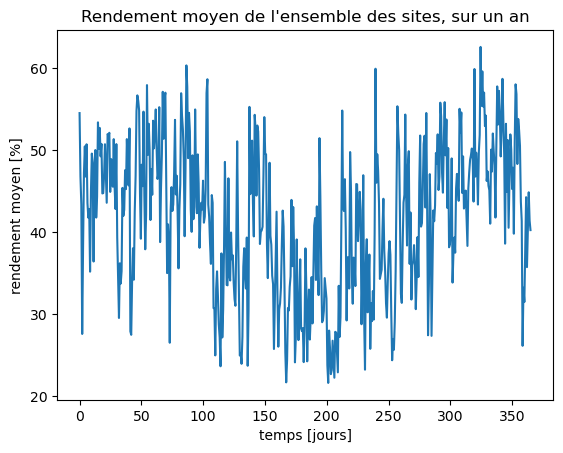

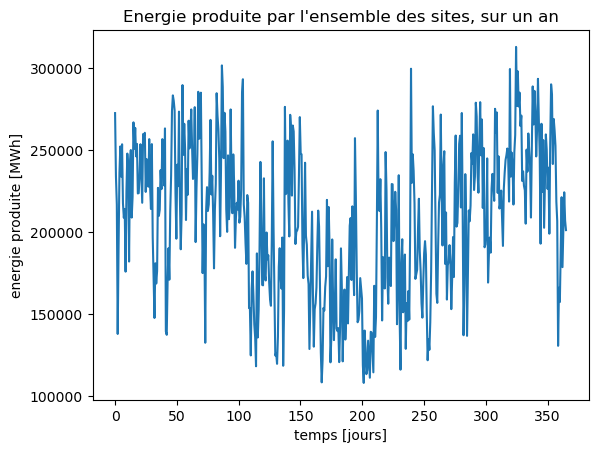

In [63]:
graph_rendements(sol.Rm, nticks = nticks, scale = scale, name = "graphe-rendementQ1")
graph_Q1energy(sol.E, nticks = nticks, scale = scale, name = "graphe-engQ1")

c:\Users\clair\Documents\CoursUCL\EPL\EPLBAC2\Q4\MAP\LINMA1702-opt1\Projet\LINMA1702\plotMap.py:26: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  


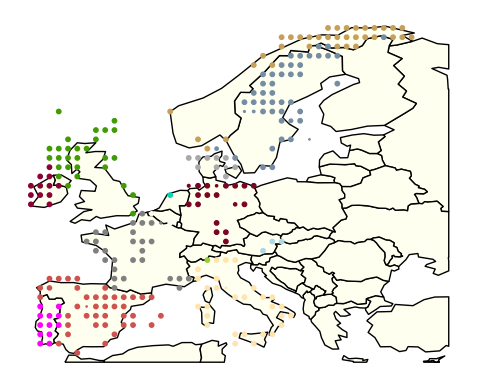

In [64]:
plotMap(data, x, name="bigIronFanQ1")

In [ ]:
xQ1,EQ1 = x,sol.E ##comparison tool

## Modèle 2
Cette partie du notebook est consacré au deuxième modèle.

Fonction pour l'optimisation du modèle 2


In [65]:
def modele2 (t, m, n, h, ct, cm, c, Rt, Rm, R, A, P, k, S, checkpoints) :
    """
    Args :
    valeurs propres au problème telles que décrites / construites
    
    Returns :
    - x, numpy array de taille n, les proportions de chaque site d'éoliennes qui seront installées,
    - s, numpy array de taille h, les quantités achetées pour chaque heure,
    - z, scalaire, la fonction objectif, minimum des productions d'énergie sur toutes les periodes d'une heure 
    """
    ## Constructing all the matrices of use for linprog
    ## v are the variables linprog will give us in return, v = (x|s|z)
    ## size of v : n + h + 1
    ## fun is the optimized objective linprog will give us in return
    ## A_ub @ v <= b_ub
    ## A_eq @ v == b_eq
    ## min (coeff @ v) = -max (-coeff @ v)

    ## max (min (x@aj)) = max z ; z <= x@aj
    ## where aj is a column of A, of size n
    ## there are h values for x@aj and we want to maximize the smaller one (z)
    
    # Contraintes d'inégalité (A_ub, b_ub) :
    # 0 <= x <= 1 pour tout x
    # z <= (aj)^Tx + sj pour tout aj colonne de A ; sj element de s
    # 0 <= s pour tout s
    # sum(sj) <= S

    # Traduit en 
    #  xi <= 1
    # -xi <= 0
    #  -(aj)^T@x - sj + z <= 0
    # -sj <= 0 
    # sum(sj) <= S

    # b_ub est de taille 2*n + 2*h + 1
    # A_ub est de dimensions (2n+2h+1,n+h+1)

    In = np.identity(n)
    A_ub1 = np.concatenate((In,-In))
    if checkpoints :
        print("Checking construction of A_ub : for now, is A_ub1 shape correct ?", np.shape(A_ub1)==(2*n, n))
    A_ub1 = np.concatenate((A_ub1, np.zeros((2*n,h+1))), axis = 1)
    if checkpoints :
        print("Checking construction of A_ub : is A_ub1 shape correct ?", np.shape(A_ub1)==(2*n, n+h+1))
    A_ub2 = np.concatenate((-np.transpose(A), -np.identity(h), np.ones((h))[:, np.newaxis]), axis = 1)
    if checkpoints :
        print("Checking construction of A_ub : is A_ub2 shape correct ?", np.shape(A_ub2)==(h, n+h+1))
    A_ub3 = np.concatenate((np.zeros((h,n)),-np.identity(h),np.zeros((h,1))), axis=1)
    if checkpoints :
        print("Checking construction of A_ub : is A_ub3 shape correct ?", np.shape(A_ub3)==(h,n+h+1))
    A_ub4 = np.concatenate((np.zeros((1,n)),np.ones((1,h)),np.zeros((1,1))), axis = 1)
    if checkpoints :
        print("Checking construction of A_ub : is A_ub4 shape correct ?", np.shape(A_ub4)==(1,n+h+1))
    A_ub = np.concatenate((A_ub1, A_ub2, A_ub3, A_ub4))
    if checkpoints :
        print("Checking construction of A_ub : is A_ub shape correct ?", np.shape(A_ub)==(2*n+2*h+1, n+h+1))
    b_ub = np.concatenate((np.ones((n)),np.zeros((n+2*h)),S*np.ones((1))))
    if checkpoints :
        print("Checking construction of b_ub : is b_ub shape correct ?", np.shape(b_ub)==(2*n+2*h+1,))

    
    # Contraintes d'égalité (A_eq, b_eq)
    # c @ x = P
    # cm @ xm = kP
    
    b_eq = np.array([P, k*P])
    A_eq1 = np.concatenate((c,np.zeros((h+1))))
    A_eq2 = np.concatenate((np.zeros((t)), cm))
    A_eq2 = np.concatenate((A_eq2, np.zeros((h+1))))
    A_eq = np.array([A_eq1, A_eq2])
    if checkpoints :
        print("Checking construction of A_eq : is A_eq shape correct ?", np.shape(A_eq)==(2,n+h+1))
    
    coeffs = np.concatenate((np.zeros((n+h)), np.array([-1])))
    if checkpoints :
        print("Checking construction of coeffs : is coeffs shape correct ?", np.shape(coeffs)==(n+h+1,))

    ## Calling linprog
    res = linprog(coeffs, A_ub, b_ub, A_eq, b_eq)

    if (res.success != True) :
        # TODO : gestion du probleme
        print("There was a trouble with the usage of linprog : the problem could not be optimized")
        print(res.message)
    
    v = res.x
    z = -res.fun
    x = v[0:n]
    s = v[n:n+h]

    if checkpoints :
        print("Checking : is x the correct size ?", len(x)==n)
        print("Checking : is s the correct size ?", len(s)==h)
        print("Sanity check : as z is the last variable and the objective for linprog, is z equal to v[-1] ?", z == v[-1])
        print("Sanity check : is the production c @ x equal to the argument P ?", abs(c@x-P)<1e-9)
        print("Sanity check : is the off-shore production cm @ xm equal to k*P ?", abs(cm@x[t:n]-k*P)<1e-9)
        print("Sanity check : is the sum of the buyings inferior to S ?", S-np.sum(s)<=1e-9)
        boundcheck = True
        for i in range (n) :
            if (x[i]<0) or (x[i]>1) :
                boundcheck = False
        print("Sanity check : are all x's taking values between 0 and 1 ?", boundcheck)
        sboundcheck = True
        for j in range (h) :
            if (s[j] < 0) :
                sboundcheck = False
        print("Sanity check : are all s's positive ?", sboundcheck)
        mincheck = True
        for i in range (h) :
            if ( z - A[:,i]@x - s[i] > 1e-9 ) :
                mincheck = False
        print("Sanity check : is z the minimum of production + buying for all hours ?", mincheck)

    return x,s,z

In [66]:
x,s,z = modele2(t,m,n,h,onshore_capa,offshore_capa,c,onshore_rend,offshore_rend,R,A,P,k,S,checkpoints)
sol = getSolution(x, A, c, h)

In [67]:
print("Minimum de l'énergie produite en une heure, ou fonction objectif : {} MWh".format(z))
print("Rendement moyen sur l'année : {} %".format(sol.Rmtot*100))
print("Energie produite en un an : {} MWh".format(sol.Etot))
print("Energie achetee sur un an : {} MWh".format(np.sum(s)))
print("Portion de l'énergie disponible produite par les sites éoliens : {} %".format(sol.Etot*100/(sol.Etot+np.sum(s))))

Minimum de l'énergie produite en une heure, ou fonction objectif : 293226.80238792027 MWh
Rendement moyen sur l'année : 45.256336685595365 %
Energie produite en un an : 1982227546.8290794 MWh
Energie achetee sur un an : 600000000.0 MWh
Portion de l'énergie disponible produite par les sites éoliens : 76.76424756846903 %


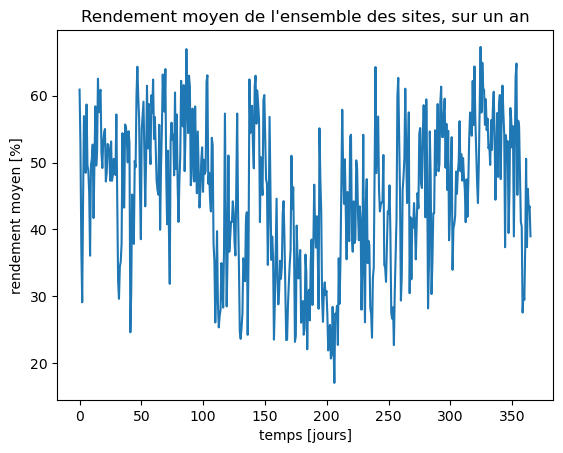

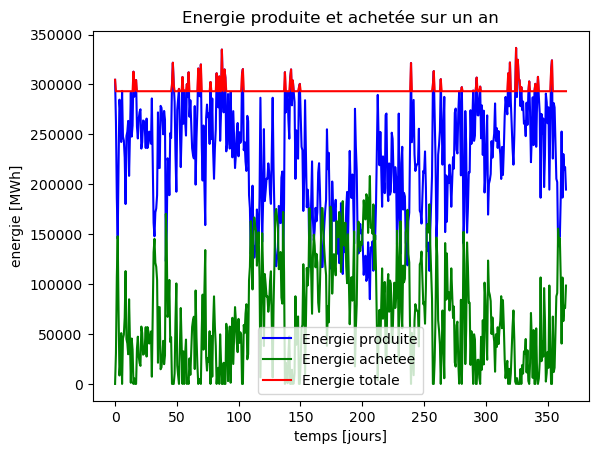

In [68]:
graph_rendements(sol.Rm, nticks = nticks, scale = scale, name = "graphe-rendementQ2")
graph_Q2energy(sol.E, s, nticks = nticks, scale = scale,name = "graphe-engQ2")

c:\Users\clair\Documents\CoursUCL\EPL\EPLBAC2\Q4\MAP\LINMA1702-opt1\Projet\LINMA1702\plotMap.py:26: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  


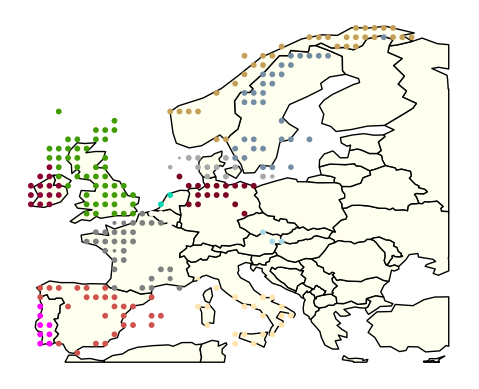

In [69]:
plotMap(data, x, name="bigIronFanQ2")

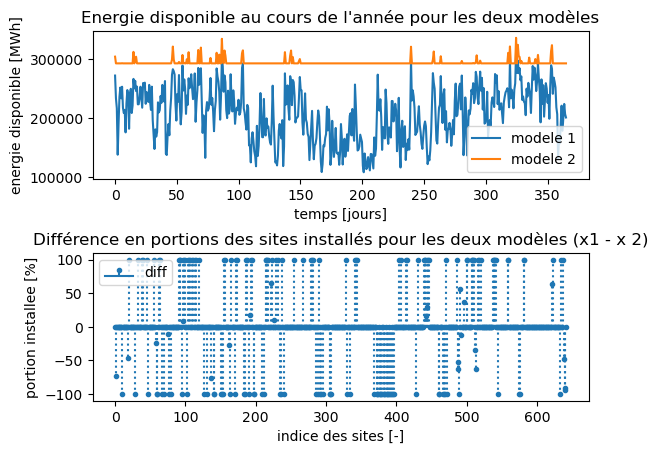

In [70]:
xQ2,EQ2 = x,sol.E+s

graph_comparison(EQ1,EQ2,xQ1,xQ2,nticks=nticks,scale=scale,name='graph-comparison-Q2',modeles=(1,2))


## Modèle 3
Cette partie du notebook est consacrée au troisième modèle.


Fonctions du troisième modèle

In [71]:
def mod3ContSup(R, c, T):
    A = np.zeros(R.shape)
    for i in range(len(c)):
        A[i] = c[i] * R[i]

    # U: matrice addition toutes les heures
    U = np.ones((A.shape[1], 1))
    # V : matrice production éolienne totale
    V = np.dot(A, U)

    # p : nombre de période et reste
    p = A.shape[1] // T
    r = A.shape[1] % T
    # On coupe la matrice car sinon il n'y a pas assez de données de remplir la dernière période
    if r != 0:
        A = A[:, :-r]
    # C :matrice pour additionner les productions d'une période
    C = np.zeros((A.shape[1], p))
    for i in range(p):
        C[i * T:(i + 1) * T, i] = 1
    # P : matrice de production par période
    P = np.dot(A, C)
    # B : matrice pour calculer les différences de productions entre période successive
    B = np.eye(p, p - 1, k=-1) - np.eye(p, p - 1)
    # E : matrice pour faire la différence entre colonnes successives
    E = np.eye(P.shape[1], P.shape[1]-1, k=-1) - np.eye(P.shape[1], P.shape[1]-1)
    # F : matrice Ak+1 - Ak
    F = np.dot(P, E)
    # G : matrice Ak - Ak+1
    G = np.dot(P, -E)

    return V[:,0], F.T, G.T

In [72]:
def modele3(t, m, n, h, ct, cm, c, Rt, Rm, R, A, P, k, delta, T, checkpoints):
    """
    Args :
    valeurs propres au problème telles que décrites / construites

    Returns :
    - x, numpy array de taille n, les proportions de chaque site d'éoliennes qui seront installées,
    - z, scalaire, la fonction objectif à maximiser, énergie produite au cours de l'année
    """

    In = np.identity(n)
    A_ub1 = np.concatenate((In, -In))
    V, F, G = mod3ContSup(R, c, T)
    m = F.shape[0] #p-1

    A_ub1 = np.concatenate((A_ub1, np.zeros((A_ub1.shape[0], m))), axis=1)
    A_ub2 = np.concatenate((F,-np.identity(F.shape[0])), axis=1)
    A_ub3 = np.concatenate((G,-np.identity(G.shape[0])), axis=1)
    A_ub4 = np.concatenate((np.zeros((1,n)), np.ones((1,m))), axis=1)
    A_ub = np.concatenate((A_ub1, A_ub2, A_ub3, A_ub4))

    b_ub1 = np.ones((n))
    b_ub2 = np.zeros((n))
    b_ub3 = np.zeros((2*m))
    b_ub4 = np.array([delta*T*P*m])
    b_ub = np.concatenate((b_ub1, b_ub2, b_ub3, b_ub4))

    # Contraintes d'égalité (A_eq, b_eq)
    # c @ x = P
    # cm @ xm = kP

    b_eq = np.array([P, k * P])
    A_eq1 = np.concatenate((c, np.zeros((m))))
    A_eq2 = np.concatenate((np.zeros((t)), cm, np.zeros((m))))
    A_eq = np.array([A_eq1, A_eq2])

    coeffs = -np.concatenate((V, np.zeros((m))))


    ## Calling linprog
    res = linprog(coeffs, A_ub, b_ub, A_eq, b_eq)

    if (res.success != True):
        print(res.message)

    v = res.x
    z = -res.fun
    x = v[0:n]

    return x, z

In [73]:
x,z = modele3(t, m, n, h, onshore_capa, offshore_capa, c, onshore_rend, offshore_rend, R, A, P, k, delta, T, checkpoints)
sol = getSolution(x, A, c, h)

print("Minimum de l'énergie produite en une heure, ou fonction objectif : {} MWh".format(z))
print("Rendement moyen sur l'année : {} %".format(sol.Rmtot*100))
print("Energie produite en un an : {} MWh".format(sol.Etot))

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -1959630168.0267851
              x: [ 1.000e+00  1.000e+00 ...  1.829e+04  3.205e+04]
            nit: 14375
          lower:  residual: [ 1.000e+00  1.000e+00 ...  1.829e+04
                              3.205e+04]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00]
                 marginals: [-2.331e+03 -1.828e+03]
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ...  6.410e+04
                              0.000e+00]
                 marginals: [-1.494e+07 -6.141e+06 ... -0.000e+00
                             -3.273e+00]
 mip_

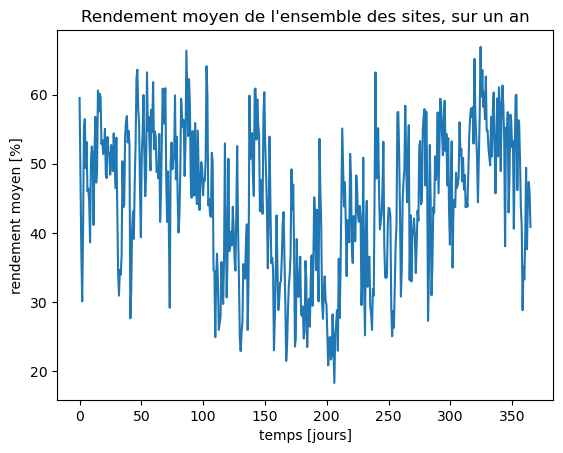

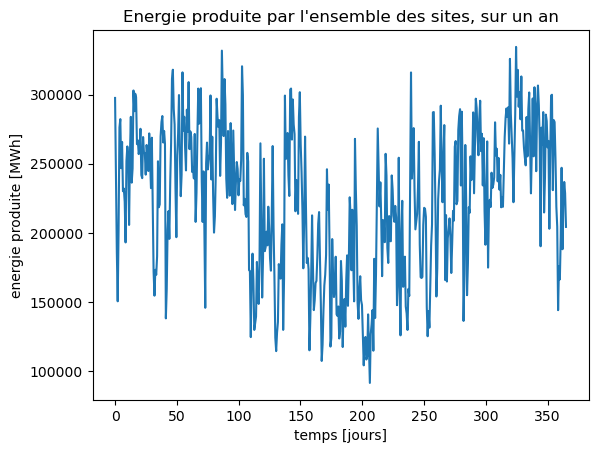

In [74]:
graph_rendements(sol.Rm, nticks = nticks, scale = scale, name = "graphe-rendementQ3")
graph_Q1energy(sol.E, nticks = nticks, scale = scale, name = "graphe-engQ3") ## vu la formulation du pb, utiliser la mm fct qu'en 1 est ok

c:\Users\clair\Documents\CoursUCL\EPL\EPLBAC2\Q4\MAP\LINMA1702-opt1\Projet\LINMA1702\plotMap.py:26: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  


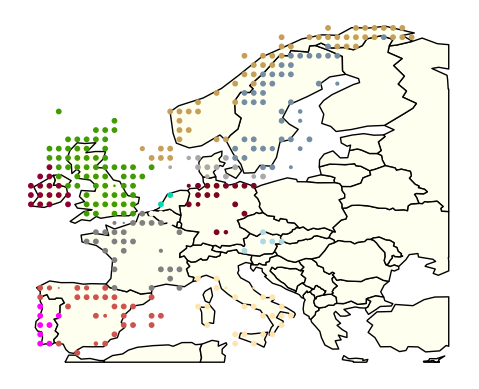

In [75]:
plotMap(data, x, name="bigIronFanQ3")

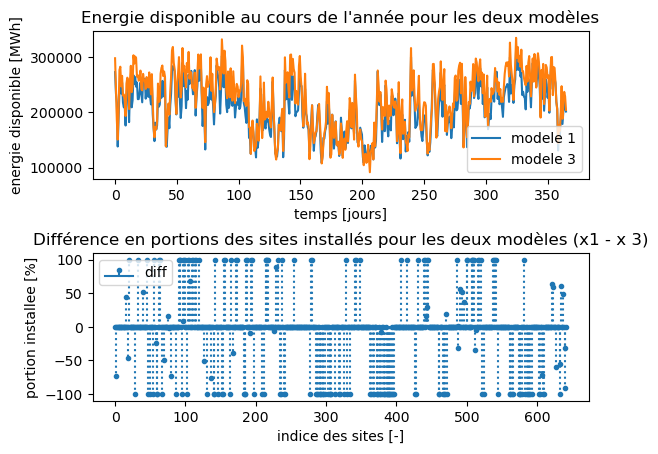

In [77]:
xQ3, EQ3 = x, sol.E
graph_comparison(EQ1,EQ3,xQ1,xQ3,nticks=nticks,scale=scale,name='graph-comparison-Q3',modeles=(1,3))